In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib # to save the scaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Conv1D, MaxPooling1D, 
                                     UpSampling1D, RepeatVector, LSTM, Lambda, Flatten, Reshape)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import itertools
import random

import keras_tuner as kt  # Keras Tuner

from pandas.plotting import autocorrelation_plot

# Set the random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

from commons import create_sequences, load_data, add_advanced_time_features, add_lag_features, filter_and_save_data, scale_data, scale_selected_columns, preprocess_data_without_scaling, preprocess_data_with_scaling, plot_anomalies
from commons import timesteps, data_file_path, time_column, target_column, train_data_split, train_data_path, eval_data_path, anomaly_trashold   # Variables which are shared across the application

In [2]:
#================================================================================================================
#new autoencoder with keras
def build_architecture(hp, **kwargs):
    """
    Build an autoencoder model using hyperparameters for architecture.
    Training parameters (epochs, batch_size) are not tuned here.
    """
    model_type = hp.Choice('model_type', ['cnn', 'lstm', 'variational'])
    encoding_dim = hp.Choice('encoding_dim', [4, 8, 16])
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0001, 0.00001])
    
    # Assume timesteps and input_dim are defined globally.
    global timesteps, input_dim

    if model_type == "cnn":
       # Modified CNN branch: Use a single pooling/upsampling pair.
        input_layer = Input(shape=(timesteps, input_dim))
        x = Conv1D(filters=hp.Int('cnn_filters1', min_value=16, max_value=32, step=8),
                   kernel_size=3, activation=activation, padding='same')(input_layer)
        # Single pooling: reduces sequence length from 10 to ceil(10/2)=5.
        x = MaxPooling1D(pool_size=2, padding='same')(x)
        x = Conv1D(filters=hp.Int('cnn_filters2', min_value=8, max_value=16, step=4),
                   kernel_size=3, activation=activation, padding='same')(x)
        # Decoder: upsample back to original length.
        x = UpSampling1D(size=2)(x)  # Upsamples: 5*2=10.
        decoded = Conv1D(filters=input_dim, kernel_size=3, activation='sigmoid', padding='same')(x)
        model = Model(inputs=input_layer, outputs=decoded)
    
    elif model_type == "lstm":
        # LSTM autoencoder.
        input_layer = Input(shape=(timesteps, input_dim))
        encoded = LSTM(encoding_dim, activation=activation, return_sequences=False)(input_layer)
        decoded = RepeatVector(timesteps)(encoded)
        decoded = LSTM(input_dim, activation=activation, return_sequences=True)(decoded)
        model = Model(inputs=input_layer, outputs=decoded)
    
    elif model_type == "variational":
        # Variational autoencoder (for demonstration)
        def sampling(args):
            z_mean, z_log_var = args
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
        input_layer = Input(shape=(timesteps, input_dim))
        flattened = Flatten()(input_layer)
        encoded = Dense(encoding_dim, activation=activation)(flattened)
        z_mean = Dense(encoding_dim)(encoded)
        z_log_var = Dense(encoding_dim)(encoded)
        z = Lambda(sampling, output_shape=(encoding_dim,))([z_mean, z_log_var])
        decoded = Dense(timesteps * input_dim, activation='sigmoid')(z)
        output = Reshape((timesteps, input_dim))(decoded)
        model = Model(inputs=input_layer, outputs=output)
    else:
        raise ValueError("Invalid model_type!")
    
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_squared_error')
    return model
#=============================================================================================================================

Trial 20 Complete [00h 02m 38s]
val_loss: 13.394157409667969

Best val_loss So Far: 1.6494719982147217
Total elapsed time: 00h 26m 32s
Best architecture hyperparameters: {'model_type': 'lstm', 'encoding_dim': 4, 'activation': 'relu', 'learning_rate': 0.001, 'cnn_filters1': 24, 'cnn_filters2': 12}
Training with epochs=50 and batch_size=32 ...
Validation loss: 1.247752070426941
Training with epochs=50 and batch_size=64 ...
Validation loss: 2.0309009552001953
Training with epochs=50 and batch_size=128 ...
Validation loss: 4.2736992835998535
Training with epochs=100 and batch_size=32 ...
Validation loss: 1.850796103477478
Training with epochs=100 and batch_size=64 ...
Validation loss: 1.2350841760635376
Training with epochs=100 and batch_size=128 ...
Validation loss: 2.8057239055633545
Training with epochs=150 and batch_size=32 ...
Validation loss: 1.5171045064926147
Training with epochs=150 and batch_size=64 ...
Validation loss: 1.6130160093307495
Training with epochs=150 and batch_size=1

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 15, 26)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 4)              │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_11 (RepeatVector) │ (None, 15, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 15, 26)         │         3,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,162 (43.61 KB)

 Trainable params: 3,720 (14.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,442 (29.07 KB)

Final model trained with the best architecture and training hyperparameters.


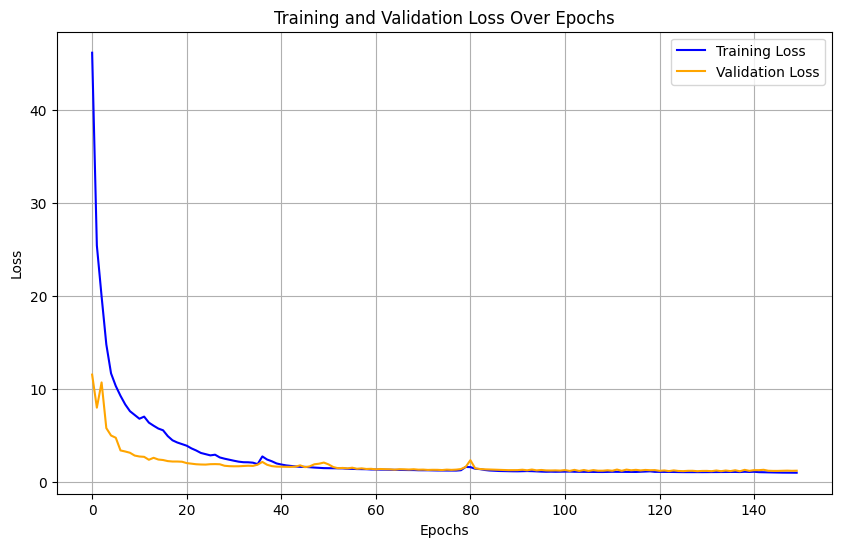

In [3]:
train_data_preprocessed =preprocess_data_without_scaling(
    train_data_path, 
    time_column, 
    target_column, 
    timesteps, 
    drop_time_column=False
)

scaler = StandardScaler()

# Apply scaling to the data
scaled_data_for_training, scaled_feature_names = scale_data(
    scaler, 
    train_data_preprocessed, 
    target_column, 
    n_lags=timesteps  # Dynamic number of lags
)

print("Scaled feature names:", scaled_feature_names)




train_data_filtered_numeric = scaled_data_for_training.drop(columns=[time_column])
#train_data_filtered['Time'] = pd.to_numeric(train_data_filtered['Time'])
print(train_data_filtered_numeric.dtypes)



# Ensure the DataFrame is numeric, then convert to a NumPy array of type float32.
X_numeric = train_data_filtered_numeric.values.astype('float32')

X_seq = create_sequences(X_numeric, timesteps)
print("Sequence data shape:", X_seq.shape)
print("Data type:", X_seq.dtype)

# Set input_dim globally based on your sequence data.
input_dim = X_seq.shape[-1]

# Set up the tuner for architecture tuning.
tuner_arch = kt.RandomSearch(
    build_architecture,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_arch_dir',
    project_name='autoencoder_arch_tuning'
)

# Run architecture search with fixed training parameters (e.g., epochs=50, batch_size=32).
# Assume X_seq is your 3D sequence data.
tuner_arch.search(X_seq, X_seq, epochs=50, batch_size=32, validation_split=0.2)

best_arch_hps = tuner_arch.get_best_hyperparameters(num_trials=1)[0]
print("Best architecture hyperparameters:", best_arch_hps.values)

# Build the best architecture model.
final_arch_model = tuner_arch.hypermodel.build(best_arch_hps)
# -------------------------------

# -------------------------------
# Phase 2: Training Hyperparameter Tuning (with architecture fixed)
# Here, we use a simple grid search over candidate epochs and batch sizes.

training_candidates = list(itertools.product([50, 100, 150], [32, 64, 128]))  # (epochs, batch_size)
best_val_loss = np.inf
best_train_params = None

for epochs_val, batch_size_val in training_candidates:
    print(f"Training with epochs={epochs_val} and batch_size={batch_size_val} ...")
    # We reinitialize the model weights for each candidate.
    model = tuner_arch.hypermodel.build(best_arch_hps)
    history = model.fit(
        X_seq, X_seq,
        epochs=epochs_val,
        batch_size=batch_size_val,
        validation_split=0.2,
        shuffle=False,
        verbose=0
    )
    current_val_loss = history.history['val_loss'][-1]
    print(f"Validation loss: {current_val_loss}")
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_train_params = (epochs_val, batch_size_val)

print("Best training parameters:", best_train_params, "with validation loss:", best_val_loss)
# -------------------------------

# --- Rebuild and Train the Final Model with the Best Architecture and Training Parameters ---
final_model = tuner_arch.hypermodel.build(best_arch_hps)
final_history = final_model.fit(
    X_seq, X_seq,
    epochs=best_train_params[0],
    batch_size=best_train_params[1],
    validation_split=0.2,
    shuffle=False,
    verbose=1
)

final_model.summary()
print("Final model trained with the best architecture and training hyperparameters.")

# --- Plot the Training History ---
def plot_training_history(history):
    """
    Plots the training and validation loss over epochs.
    
    Parameters:
      - history: Keras History object containing training/validation loss values.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)

In [4]:
trained_feature_names = train_data_filtered_numeric.columns

last_x_days_data = preprocess_data_with_scaling(
    eval_data_path, 
    time_column, 
    target_column, 
    timesteps,
    scaler,
    drop_time_column=False
)
# Drop the 'Time' column before fitting the model, as IsolationForest only accepts numeric features
last_x_days_data_numeric = last_x_days_data.drop(columns=[time_column])
print(last_x_days_data_numeric.head())
# Ensure you are selecting only the same features in last_x_days_data
last_x_days_data_filtered = last_x_days_data[trained_feature_names]
last_x_days_data_filtered


# --- Step 1: Create sequences from numeric data ---
if isinstance(last_x_days_data_filtered, pd.DataFrame):
    eval_numeric = last_x_days_data_filtered.values.astype('float32')
else:
    eval_numeric = np.asarray(last_x_days_data_filtered, dtype=np.float32)

# Convert the 2D evaluation data into overlapping sequences.
eval_sequences = create_sequences(eval_numeric, timesteps)
print("Evaluation sequences shape:", eval_sequences.shape)
print("Evaluation data type:", eval_sequences.dtype)

# --- Step 2: Compute Representative Timestamps for Each Sequence ---
# Here, we choose the last timestamp of each window.
if time_column in last_x_days_data.columns:
    time_values = last_x_days_data[time_column].values
    time_sequences = []
    for i in range(len(time_values) - timesteps + 1):
        time_sequences.append(time_values[i:i+timesteps])
    # Representative time is the last time in each sequence.
    rep_times = [seq[-1] for seq in time_sequences]
else:
    # If no Time column, use the sequence index as a fallback.
    rep_times = np.arange(len(eval_sequences)).astype(str)

# --- Step 3: Use the Autoencoder to Reconstruct the Sequences ---
reconstructed_eval = final_model.predict(eval_sequences)

# --- Step 4: Calculate Reconstruction Error per Sequence ---
# Calculate mean absolute error across timesteps and features.
reconstruction_errors = np.mean(np.abs(eval_sequences - reconstructed_eval), axis=(1, 2))
print("Reconstruction errors shape:", reconstruction_errors.shape)

# --- Step 5: Define an Anomaly Threshold and Label Anomalies ---
threshold = np.percentile(reconstruction_errors, anomaly_trashold)
print("Anomaly threshold:", threshold)
anomaly_labels = (reconstruction_errors > threshold).astype(int)

# --- Step 6: Create the Sequence-level Results DataFrame ---
results_df = pd.DataFrame({
    time_column: rep_times,
    'reconstruction_error': reconstruction_errors,
    'anomaly': anomaly_labels
})
print("Sequence-level anomaly results:")
print(results_df.head())

# --- Step 7: Prepare the Original Data for Comparison ---
# Ensure that the original DataFrame has a datetime column "Time".

last_x_days_data = last_x_days_data.copy()  # Ensure you're working with a new object
last_x_days_data.loc[:, time_column] = pd.to_datetime(last_x_days_data.loc[:, time_column])

# Create a "Date" column by extracting the date.
last_x_days_data.loc[:, 'Date'] = last_x_days_data.loc[:, time_column].dt.date
results_df.loc[:, 'Date'] = pd.to_datetime(results_df[time_column]).dt.date

# --- Step 8: Compare the Two Data Sets by Date ---
# For example, group by Date and count rows.
original_counts = last_x_days_data.groupby('Date').size().rename('original_count')
results_counts = results_df.groupby('Date').size().rename('results_count')

# Merge the counts into one DataFrame.
comparison_df = pd.concat([original_counts, results_counts], axis=1).fillna(0)
comparison_df['difference'] = comparison_df['original_count'] - comparison_df['results_count']

print("\nComparison of row counts by Date:")
print(comparison_df)

NaN counts before preprocessing:
timestamp    0
value        0
dtype: int64
NaN counts after adding time features:
timestamp       0
value           0
hour            0
day             0
day_of_week     0
week_of_year    0
month           0
is_weekend      0
hour_sin        0
hour_cos        0
dtype: int64
       value  hour  day  day_of_week  week_of_year  month  is_weekend  \
15 -0.856676    22    2            0            49     12           0   
16 -0.756508    22    2            0            49     12           0   
17 -0.761810    22    2            0            49     12           0   
18 -0.728146    22    2            0            49     12           0   
19 -0.888284    22    2            0            49     12           0   

    hour_sin  hour_cos     lag_1  ...     lag_8     lag_9    lag_10    lag_11  \
15      -0.5  0.866025 -0.867372  ... -0.878055 -0.878316 -1.043680 -0.977891   
16      -0.5  0.866025 -0.856611  ... -0.869505 -0.877993 -0.878247 -1.043605   
17      -0

C:\Users\b50578\OneDrive - FH CAMPUS 02\Documents\PhD\ProjectsSandbox\Ensemble\commons.py:239: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', inplace=True)


709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Reconstruction errors shape: (22663,)
Anomaly threshold: 2.61308
Sequence-level anomaly results:
            timestamp  reconstruction_error  anomaly
0 2013-12-02 23:40:00              1.218578        0
1 2013-12-02 23:45:00              1.203413        0
2 2013-12-02 23:50:00              1.193465        0
3 2013-12-02 23:55:00              1.195040        0
4 2013-12-03 00:00:00              1.984102        0

Comparison of row counts by Date:
            original_count  results_count  difference
Date                                                 
2013-12-02              18              4          14
2013-12-03             288            288           0
2013-12-04             288            288           0
2013-12-05             288            288           0
2013-12-06             288            288           0
...                    ...            ...         ...
2014-02-15             288            288           0
2014-02-16             

In [5]:
print(last_x_days_data[time_column].is_unique)
print(results_df[time_column].is_unique)

False
False


In [6]:
# Adjust the data so that only timestamps that appear in results_df are kept.
merged_df = last_x_days_data[last_x_days_data[time_column].isin(results_df[time_column])].merge(
    results_df, on=time_column, how='left'
)

In [7]:
merged_df

,timestamp,value,hour,day,day_of_week,week_of_year,month,is_weekend,hour_sin,hour_cos,...,lag_12,lag_13,lag_14,lag_15,moving_mean_288,moving_std_288,Date_x,reconstruction_error,anomaly,Date_y
0,2013-12-02 23:40:00,-0.617307,23,2,0,49,12,0,-0.258819,0.965926,...,-0.761007,-0.755639,-0.855752,-0.866441,-0.989588,-1.207802,2013-12-02,1.218578,0,2013-12-02
1,2013-12-02 23:45:00,-0.724711,23,2,0,49,12,0,-0.258819,0.965926,...,-0.727337,-0.760942,-0.755566,-0.855678,-0.987158,-1.213938,2013-12-02,1.203413,0,2013-12-02
2,2013-12-02 23:50:00,-0.741786,23,2,0,49,12,0,-0.258819,0.965926,...,-0.887502,-0.727272,-0.760869,-0.755493,-0.986342,-1.220212,2013-12-02,1.193465,0,2013-12-02
3,2013-12-02 23:55:00,-0.755238,23,2,0,49,12,0,-0.258819,0.965926,...,-0.719249,-0.887438,-0.727198,-0.760796,-0.986607,-1.226041,2013-12-02,1.195040,0,2013-12-02
4,2013-12-03 00:00:00,-0.705106,0,3,1,49,12,0,0.000000,1.000000,...,-0.773080,-0.719184,-0.887366,-0.727125,-0.983351,-1.229457,2013-12-03,1.984102,0,2013-12-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22682,2014-02-19 14:50:00,0.954054,14,19,2,8,2,0,-0.500000,-0.866025,...,0.877779,0.724737,0.648436,0.743558,0.603723,-0.857962,2014-02-19,1.120047,0,2014-02-19
22683,2014-02-19 14:55:00,1.019096,14,19,2,8,2,0,-0.500000,-0.866025,...,0.674121,0.877853,0.724826,0.648509,0.611493,-0.878731,2014-02-19,1.149612,0,2014-02-19
22684,2014-02-19 15:00:00,0.934020,15,19,2,8,2,0,-0.707107,-0.707107,...,0.696188,0.674194,0.877944,0.724899,0.617602,-0.890095,2014-02-19,1.185389,0,2014-02-19
22685,2014-02-19 15:05:00,1.021479,15,19,2,8,2,0,-0.707107,-0.707107,...,0.916375,0.696261,0.674283,0.878017,0.623210,-0.892953,2014-02-19,1.160415,0,2014-02-19


Merged DataFrame sample:
            timestamp     value  hour  day  day_of_week  week_of_year  month  \
0 2013-12-02 23:40:00 -0.617307    23    2            0            49     12   
1 2013-12-02 23:45:00 -0.724711    23    2            0            49     12   
2 2013-12-02 23:50:00 -0.741786    23    2            0            49     12   
3 2013-12-02 23:55:00 -0.755238    23    2            0            49     12   
4 2013-12-03 00:00:00 -0.705106     0    3            1            49     12   

   is_weekend  hour_sin  hour_cos  ...    lag_12    lag_13    lag_14  \
0           0 -0.258819  0.965926  ... -0.761007 -0.755639 -0.855752   
1           0 -0.258819  0.965926  ... -0.727337 -0.760942 -0.755566   
2           0 -0.258819  0.965926  ... -0.887502 -0.727272 -0.760869   
3           0 -0.258819  0.965926  ... -0.719249 -0.887438 -0.727198   
4           0  0.000000  1.000000  ... -0.773080 -0.719184 -0.887366   

     lag_15  moving_mean_288  moving_std_288      Date_x  \
0

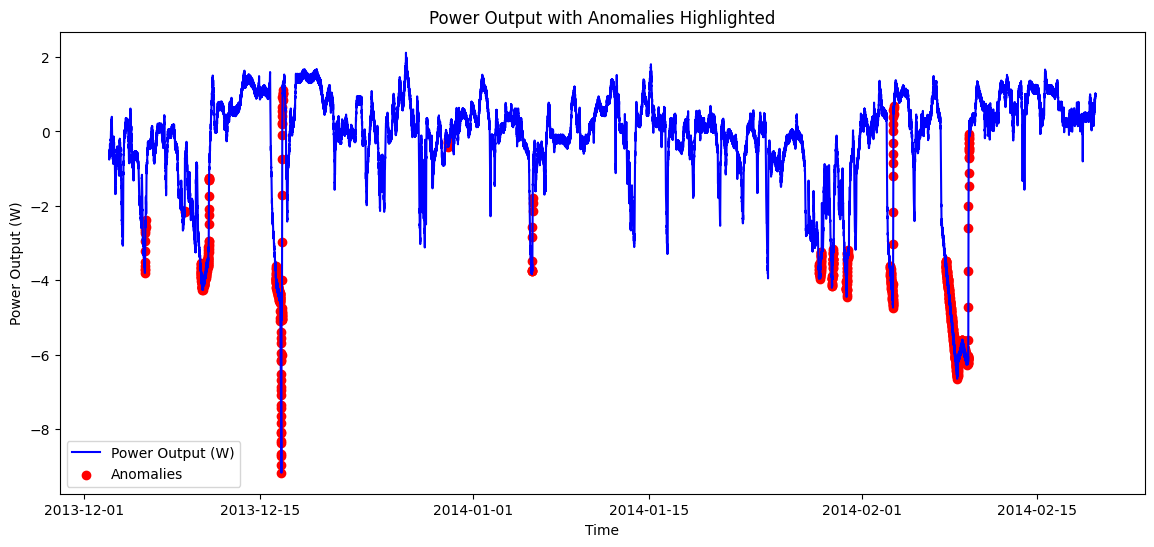

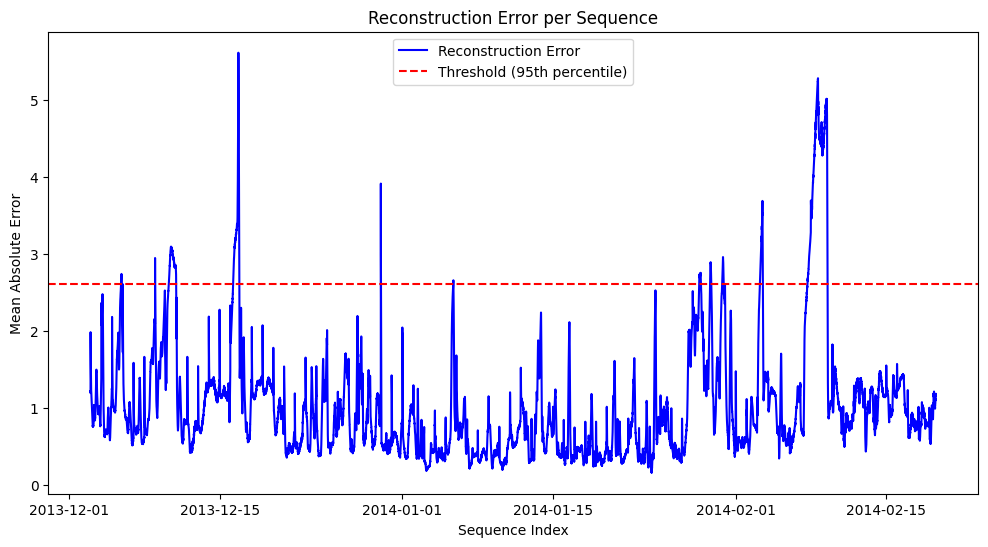

Anomalies detected at the following times:
                timestamp  reconstruction_error
822   2013-12-05 20:10:00              2.623097
823   2013-12-05 20:15:00              2.637415
824   2013-12-05 20:20:00              2.649944
825   2013-12-05 20:25:00              2.660726
826   2013-12-05 20:30:00              2.680230
...                   ...                   ...
19756 2014-02-09 13:00:00              3.475510
19757 2014-02-09 13:05:00              3.256964
19758 2014-02-09 13:10:00              3.058677
19759 2014-02-09 13:15:00              2.858124
19760 2014-02-09 13:20:00              2.656170

[1134 rows x 2 columns]


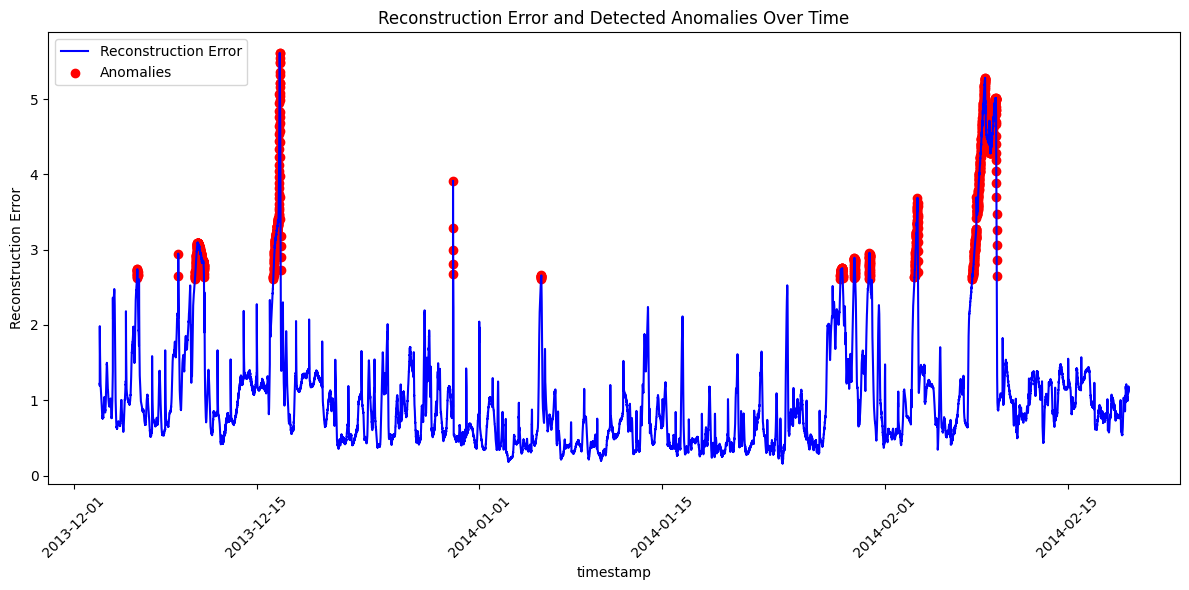

Model saved to 'best_autoencoder_model.keras'


['USModels/scaler_ae_15.pkl']

In [8]:
# Merge results_df with last_x_days_data based on "Time" if possible.
#merged_df = last_x_days_data.merge(results_df, on=time_column, how='left', validate='one_to_one')
merged_df.fillna({'reconstruction_error': 0, 'anomaly': 0}, inplace=True)
#old code for merging (deprecated due If results_df has fewer timestamps than last_x_days_data, it will introduce NaN values in the merged DataFrame.)
#merged_df = pd.merge(last_x_days_data, results_df, left_on='Time', right_on='Time', how='left')
print("Merged DataFrame sample:")
print(merged_df.head())

# Plot anomalies using the merged DataFrame.
plot_anomalies(merged_df, time_column=time_column, value_column=target_column, anomaly_column='anomaly')

# (Optional) Plot the reconstruction errors per sequence.
plt.figure(figsize=(12, 6))
plt.plot(results_df[time_column], results_df['reconstruction_error'], label='Reconstruction Error', color='blue')
# old code If results_df has non-sequential indices, the x-axis could be misleading.
#plt.plot(results_df.index, results_df['reconstruction_error'], label='Reconstruction Error', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold (95th percentile)')
plt.title('Reconstruction Error per Sequence')
plt.xlabel('Sequence Index')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


# Filter the DataFrame to include only anomalies.
anomaly_times_df = results_df[results_df['anomaly'] == 1]

# Print the times (and associated reconstruction errors) when anomalies occurred.
print("Anomalies detected at the following times:")
print(anomaly_times_df[[time_column, 'reconstruction_error']])

# Optionally, plot the reconstruction errors over time with anomalies highlighted.
plt.figure(figsize=(12, 6))
plt.plot(results_df[time_column], results_df['reconstruction_error'], label='Reconstruction Error', color='blue')
plt.scatter(anomaly_times_df[time_column], anomaly_times_df['reconstruction_error'], color='red', label='Anomalies')
plt.title('Reconstruction Error and Detected Anomalies Over Time')
plt.xlabel(time_column)
plt.ylabel('Reconstruction Error')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Saving the trained autoencoder model
# Define the path for saving the model
model_save_path = f'USModels/best_seq_autoencoder_model_{timesteps}.keras'
scaler_save_path =f'USModels/scaler_ae_{timesteps}.pkl'
# Save the trained model to a file
final_model.save(model_save_path)  # Save to an HDF5 file
print("Model saved to 'best_autoencoder_model.keras'")

# Save the scaler
joblib.dump(scaler, scaler_save_path)


## Import the model

In [9]:
last_x_days_data.head()

,timestamp,value,hour,day,day_of_week,week_of_year,month,is_weekend,hour_sin,hour_cos,...,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,moving_mean_288,moving_std_288,Date
15,2013-12-02 22:30:00,-0.856676,22,2,0,49,12,0,-0.5,0.866025,...,-0.878316,-1.043680,-0.977891,-1.103985,-1.317861,-1.443862,-1.546545,-1.125353,-1.427530,2013-12-02
16,2013-12-02 22:35:00,-0.756508,22,2,0,49,12,0,-0.5,0.866025,...,-0.877993,-0.878247,-1.043605,-0.977829,-1.103922,-1.317794,-1.443788,-1.059068,-1.294191,2013-12-02
17,2013-12-02 22:40:00,-0.761810,22,2,0,49,12,0,-0.5,0.866025,...,-0.869442,-0.877924,-0.878172,-1.043544,-0.977765,-1.103853,-1.317720,-1.039312,-1.305008,2013-12-02
18,2013-12-02 22:45:00,-0.728146,22,2,0,49,12,0,-0.5,0.866025,...,-0.961410,-0.869374,-0.877849,-0.878109,-1.043480,-0.977695,-1.103779,-1.018296,-1.298609,2013-12-02
19,2013-12-02 22:50:00,-0.888284,22,2,0,49,12,0,-0.5,0.866025,...,-0.823840,-0.961343,-0.869298,-0.877786,-0.878045,-1.043410,-0.977622,-1.048074,-1.261249,2013-12-02


In [10]:
results_df.head()

,timestamp,reconstruction_error,anomaly,Date
0,2013-12-02 23:40:00,1.218578,0,2013-12-02
1,2013-12-02 23:45:00,1.203413,0,2013-12-02
2,2013-12-02 23:50:00,1.193465,0,2013-12-02
3,2013-12-02 23:55:00,1.195040,0,2013-12-02
4,2013-12-03 00:00:00,1.984102,0,2013-12-03
